In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout, SimpleRNN, Input, GRU
from keras.models import Model
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history
import tensorflow as tf
%matplotlib inline

In [2]:
import os
os.chdir('../')
path = os.getcwd()
print(path)

C:\home\program


In [3]:
data = pd.read_csv("scraping/Weight2018-2019.csv")
sport = pd.read_csv("scraping/sport2013-2020.csv")

In [4]:
data.set_index('date')
dateTimeIndex = pd.DatetimeIndex(data['date'])
data.index = dateTimeIndex
data = data.resample('D').interpolate()
data.drop('date', axis=1)

,weight,FX
date,,
2018-01-01,0,112.640000
2018-01-02,0,112.280000
2018-01-03,0,112.490000
2018-01-04,0,112.740000
2018-01-05,0,113.060000
...,...,...
2019-01-27,0,109.403333
2019-01-28,0,109.340000
2019-01-29,0,109.380000


In [9]:
sport.set_index('Unnamed: 0')
dateTimeIndex = pd.DatetimeIndex(sport['Unnamed: 0'])
sport.index = dateTimeIndex
sport = sport.drop('Unnamed: 0', axis=1)

In [10]:
data['sport'] =  sport['2018-01-01':'2019-01-31']

In [11]:
scale = pd.DataFrame(np.nan_to_num(np.log(data['FX'].values + 1)))
scale.index = data.index.values

scale['second'] = np.nan_to_num(np.log(data['weight'].values + 1))
X_day_second = data.index.values

scale['third'] = np.nan_to_num(np.log(data['sport'].values + 1))
X_day_third = data.index.values

C:\home\anaconda\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [12]:
X_orig = np.nan_to_num(np.log(data['FX'].values + 1))
X_day = data.index.values

X_orig_second = np.nan_to_num(np.log(data['weight'].values + 1))
X_day_second = data.index.values

X_orig_third = np.nan_to_num(np.log(data['sport'].values + 1))
X_day_third = data.index.values

C:\home\anaconda\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [13]:
half = round(len(X_orig)/2)

X_train = X_orig[:half-1]
X_test = X_orig[half:]
X_train_day = X_day[:half-1]
X_test_day = X_day[half:]

X_train_second = X_orig_second[:half-1]
X_test_second = X_orig_second[half:]
X_train_day_second = X_day_second[:half-1]
X_test_day_second = X_day_second[half:]

X_train_third = X_orig_third[:half-1]
X_test_third = X_orig_third[half:]
X_train_day_third = X_day_third[:half-1]
X_test_day_third = X_day_third[half:]

In [14]:
def show_graph(day, data, label, color="b", ylabel='stock price'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()

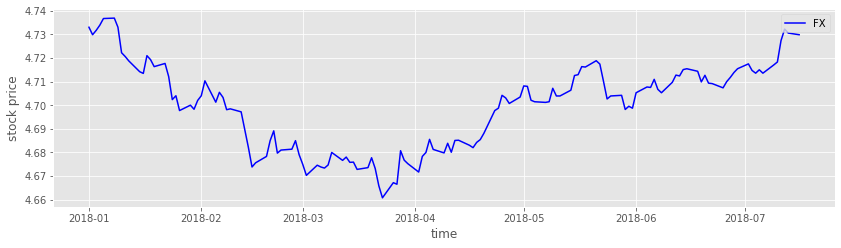

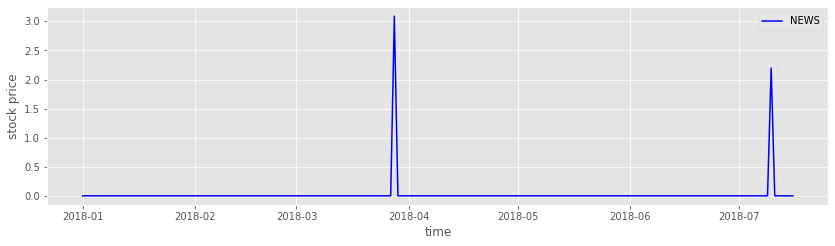

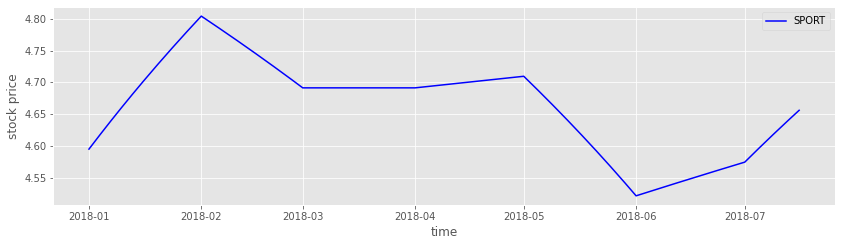

In [15]:
import pylab
plt.style.use('ggplot')
show_graph(X_train_day, X_train, 'FX')
show_graph(X_train_day_second, X_train_second, 'NEWS')
show_graph(X_train_day_third, X_train_third, 'SPORT')

In [16]:
X_train_joint = np.vstack((X_train, X_train_second, X_train_third))
X_test_joint = np.vstack((X_test, X_test_second, X_test_third))

X_train_joint.shape

(3, 197)

In [17]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

In [18]:
def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

In [19]:
def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler

In [20]:
time_steps = 3
variable_number = 3

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)

(3, 197)
(197, 3)
before max 4.733035556985987
Normalize
after max 0.9860063136763673
(3, 197)


In [21]:
input_dim = x.shape[-1]
timesteps = x.shape[1]

In [22]:
def create_model(input_dim,time_steps,latent_dim,model_option,batch_size=1,optimizer='adam'):
    with tf.name_scope('Model'):
        x = Input(shape=(time_steps, input_dim,))

        if model_option == 'lstm':
            with tf.name_scope('LSTM'):
                h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
        elif model_option == 'gru':
            with tf.name_scope('GRU'):
                h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

        print('input_dim:', input_dim)
        with tf.name_scope('Dense'):
            out = Dense(input_dim)(h)

        model = Model(x, out)
        model.summary()

        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

In [23]:
from copy import copy 

def predict_model_show_graph(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[-1]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[:, 0, i], color='r', label='data')
        plt.plot(preds[:, 0, i], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(preds, prepare_value))
    return preds, prepare_value
    # return predict_scale, x_scale

In [24]:
predict_list = []
var_list = []

print(x.shape)
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='lstm')

(197, 3, 3)
input_dim: 3
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 3)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 3, 120)            59520     
_________________________________________________________________
dense (Dense)                (None, 3, 3)              363       
Total params: 59,883
Trainable params: 59,883
Non-trainable params: 0
_________________________________________________________________


In [25]:
import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.10f}s".format(title, time.time() - t0))

Epoch 1/300
7/7 [==============================] - 4s 211ms/step - loss: 0.5266 - mse: 0.5266
Epoch 2/300
7/7 [==============================] - 0s 4ms/step - loss: 0.3659 - mse: 0.3659
Epoch 3/300
7/7 [==============================] - 0s 3ms/step - loss: 0.2327 - mse: 0.2327
Epoch 4/300
7/7 [==============================] - 0s 4ms/step - loss: 0.1526 - mse: 0.1526
Epoch 5/300
7/7 [==============================] - 0s 3ms/step - loss: 0.1405 - mse: 0.1405
Epoch 6/300
7/7 [==============================] - 0s 3ms/step - loss: 0.1215 - mse: 0.1215
Epoch 7/300
7/7 [==============================] - 0s 3ms/step - loss: 0.1028 - mse: 0.1028
Epoch 8/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0925 - mse: 0.0925
Epoch 9/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0793 - mse: 0.0793
Epoch 10/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0672 - mse: 0.0672
Epoch 11/300
7/7 [==============================] - 0s 3ms/step - loss: 0.054

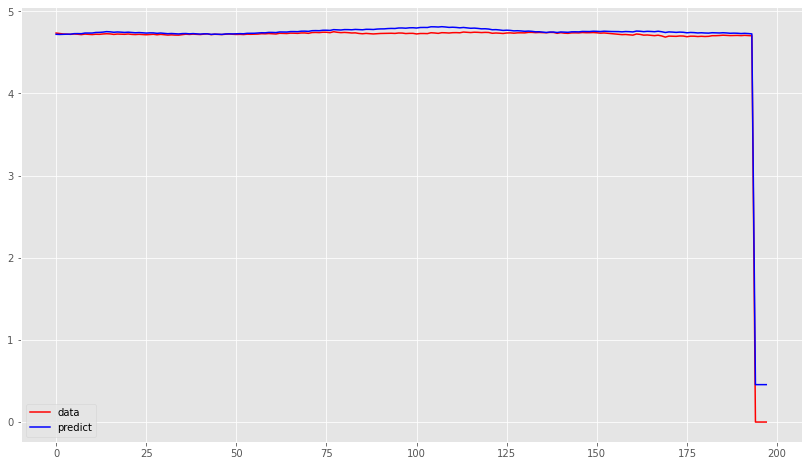

x_scale:  (198, 3, 3)


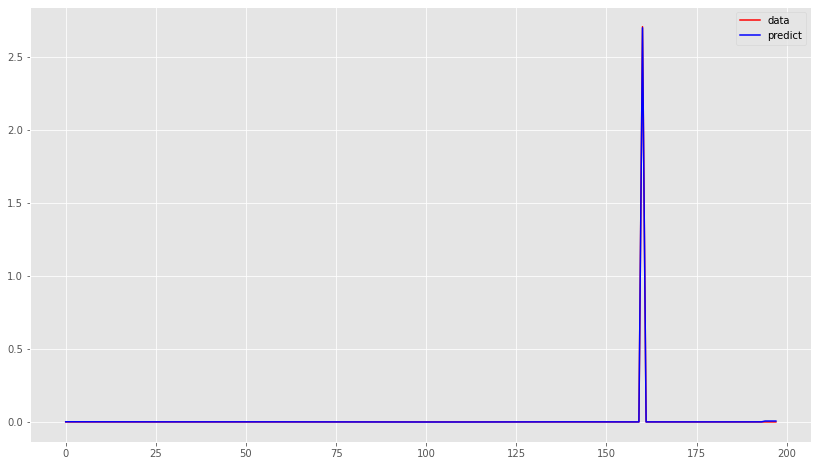

x_scale:  (198, 3, 3)


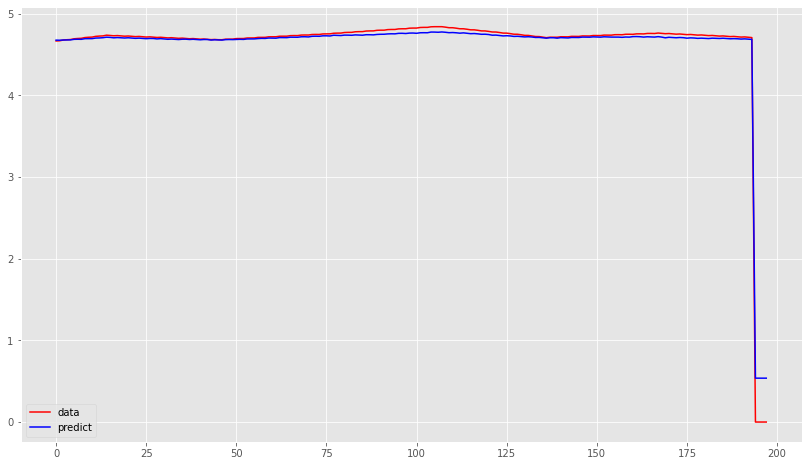

7/7 [==============================] - 0s 3ms/step - loss: 0.3185 - mse: 0.3185
model evaluate mse: [0.31847095489501953, 0.31847095489501953]


In [26]:
from pathlib import Path
from keras.callbacks import TensorBoard

log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=300, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [28]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.0485133641717693
rmse: 0.0018654791070111432
rmse: 0.0509027708317441
0.033760538036841516


In [29]:
lstm_test = np.exp(x_scale_test[:, 0, 0])
lstm_pred = np.exp(predict_test[:, 0, 0])

In [30]:
F_lstm_predict = pd.DataFrame(lstm_pred)
F_lstm_predict.index = X_day_second[half:]

F_lstm_test = pd.DataFrame(lstm_test)
F_lstm_test.index = X_day[half:]

# GRU

In [31]:
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='gru')

input_dim: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 3)]            0         
_________________________________________________________________
gru (GRU)                    (None, 3, 120)            45000     
_________________________________________________________________
dense_1 (Dense)              (None, 3, 3)              363       
Total params: 45,363
Trainable params: 45,363
Non-trainable params: 0
_________________________________________________________________


Epoch 1/300
7/7 [==============================] - 2s 72ms/step - loss: 0.4610 - mse: 0.4610
Epoch 2/300
7/7 [==============================] - 0s 3ms/step - loss: 0.2147 - mse: 0.2147
Epoch 3/300
7/7 [==============================] - 0s 3ms/step - loss: 0.1015 - mse: 0.1015
Epoch 4/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0930 - mse: 0.0930
Epoch 5/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0657 - mse: 0.0657
Epoch 6/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0507 - mse: 0.0507
Epoch 7/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0410 - mse: 0.0410
Epoch 8/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0303 - mse: 0.0303
Epoch 9/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0229 - mse: 0.0229
Epoch 10/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0161 - mse: 0.0161
Epoch 11/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0115

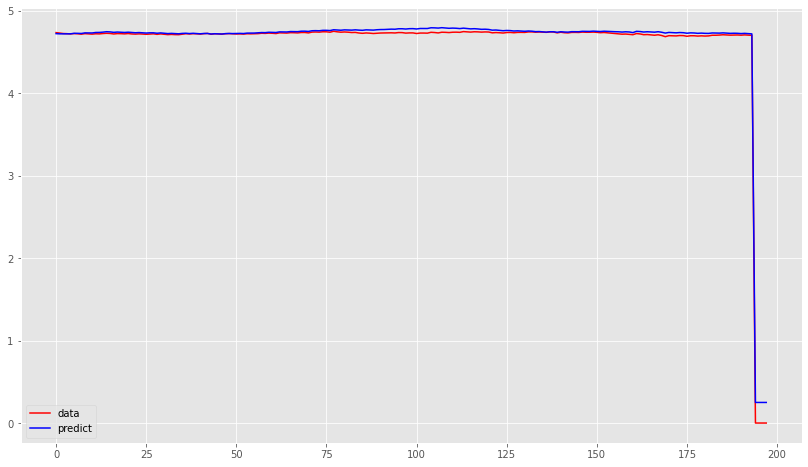

x_scale:  (198, 3, 3)


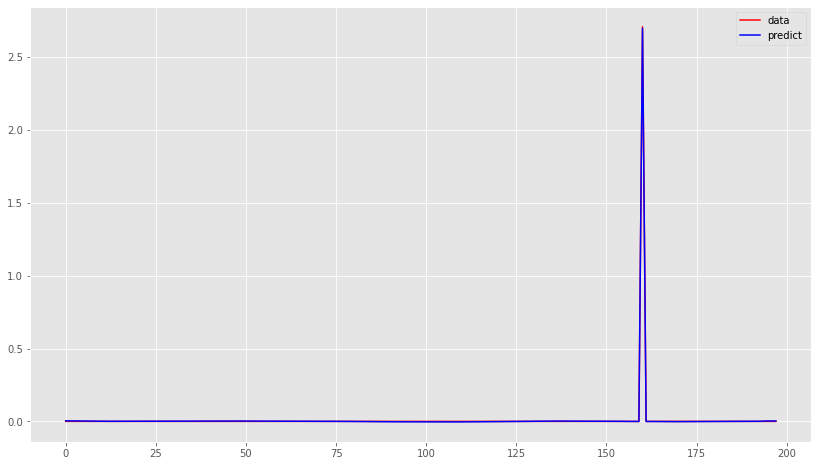

x_scale:  (198, 3, 3)


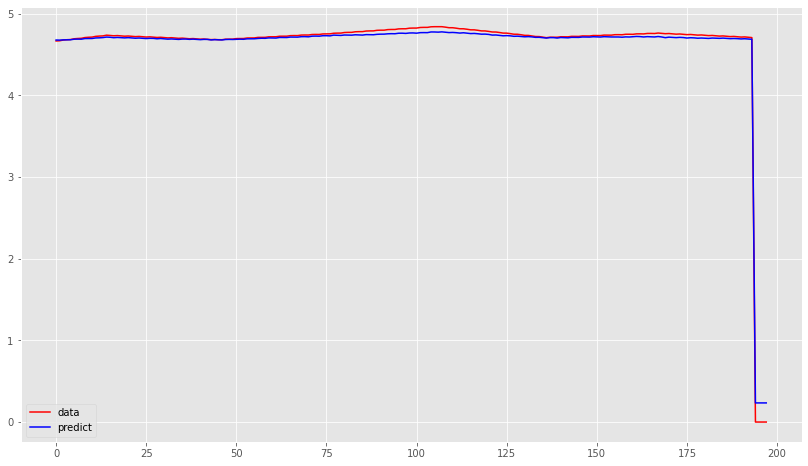

7/7 [==============================] - 0s 1ms/step - loss: 0.1955 - mse: 0.1955
model evaluate mse: [0.19554150104522705, 0.19554151594638824]


In [32]:
log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=300, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [33]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.0271250011930283
rmse: 0.00903865848321401
rmse: 0.028922086509238717
0.02169524872849368


In [34]:
gru_test = np.exp(x_scale_test[:, 0, 0])
gru_pred = np.exp(predict_test[:, 0, 0])

In [35]:
F_gru_predict = pd.DataFrame(gru_pred)
F_gru_predict.index = X_day_second[half:]

F_gru_test = pd.DataFrame(gru_test)
F_gru_test.index = X_day[half:]

# plot

In [37]:
F_lstm_test = F_lstm_test.drop(F_lstm_test.index[[len(F_lstm_test)-1,len(F_lstm_test)-2, len(F_lstm_test)-3, len(F_lstm_test)-4]])
F_lstm_predict = F_lstm_predict.drop(F_lstm_predict.index[[len(F_lstm_predict)-1,len(F_lstm_predict)-2, len(F_lstm_predict)-3, len(F_lstm_predict)-4]])
F_gru_test = F_gru_test.drop(F_gru_test.index[[len(F_gru_test)-1,len(F_gru_test)-2, len(F_gru_test)-3, len(F_gru_test)-4]])
F_gru_predict = F_gru_predict.drop(F_gru_predict.index[[len(F_gru_predict)-1,len(F_gru_predict)-2, len(F_gru_predict)-3, len(F_gru_predict)-4]])

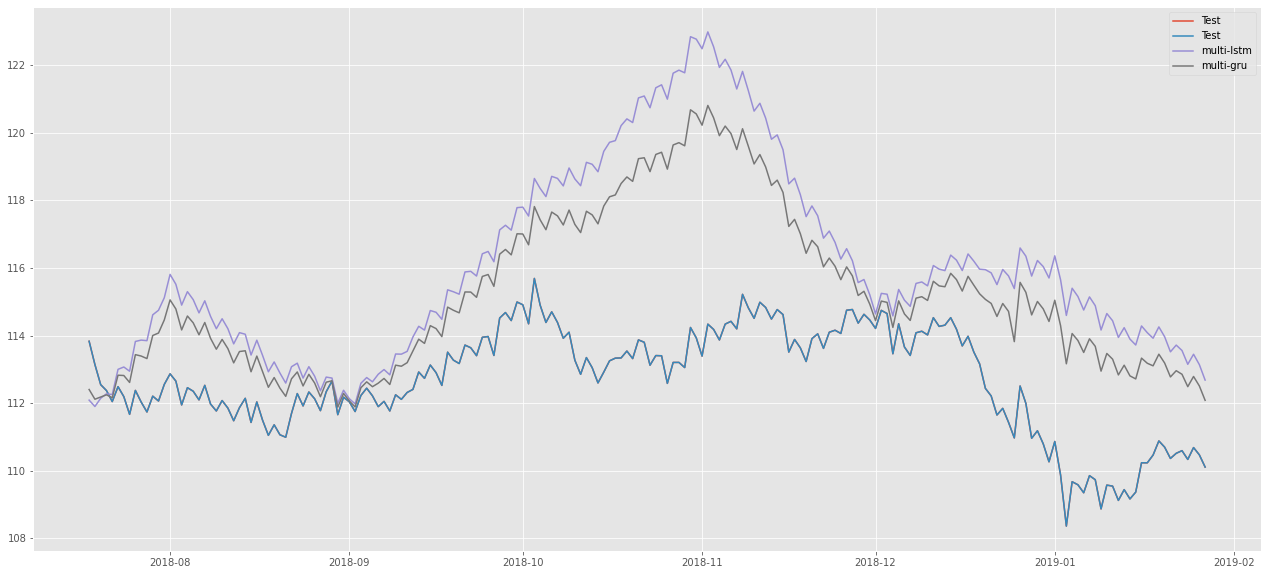

In [38]:
plt.figure(figsize=(22,10))
plt.plot(F_lstm_test, label = 'Test')
plt.plot(F_gru_test, label = 'Test')
plt.plot(F_lstm_predict, label = 'multi-lstm')
plt.plot(F_gru_predict, label = 'multi-gru')
plt.legend(loc='best')
plt.savefig('卒業論文関係/FX-SPORT-multi-epoch300.png')

# simple

In [39]:
L = len(data['FX'])
Y = data['FX']  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [40]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [41]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [42]:
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [43]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [44]:
# train, testデータを定義
X_train = X[:half-1, :, :]
X_test = X[half:, :, :]
Y_train = Y[:half-1, :]
YN_test = Y[half:, :]

# lstm

In [45]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh',batch_input_shape=(None, 1, timesteps), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(10))
model.add(Dense(1))

Epoch 1/300
7/7 - 2s - loss: 0.2191 - mean_absolute_error: 0.4206
Epoch 2/300
7/7 - 0s - loss: 0.1714 - mean_absolute_error: 0.3658
Epoch 3/300
7/7 - 0s - loss: 0.1311 - mean_absolute_error: 0.3124
Epoch 4/300
7/7 - 0s - loss: 0.0979 - mean_absolute_error: 0.2628
Epoch 5/300
7/7 - 0s - loss: 0.0711 - mean_absolute_error: 0.2206
Epoch 6/300
7/7 - 0s - loss: 0.0502 - mean_absolute_error: 0.1862
Epoch 7/300
7/7 - 0s - loss: 0.0357 - mean_absolute_error: 0.1607
Epoch 8/300
7/7 - 0s - loss: 0.0262 - mean_absolute_error: 0.1404
Epoch 9/300
7/7 - 0s - loss: 0.0207 - mean_absolute_error: 0.1229
Epoch 10/300
7/7 - 0s - loss: 0.0182 - mean_absolute_error: 0.1131
Epoch 11/300
7/7 - 0s - loss: 0.0170 - mean_absolute_error: 0.1073
Epoch 12/300
7/7 - 0s - loss: 0.0164 - mean_absolute_error: 0.1039
Epoch 13/300
7/7 - 0s - loss: 0.0158 - mean_absolute_error: 0.1014
Epoch 14/300
7/7 - 0s - loss: 0.0153 - mean_absolute_error: 0.0995
Epoch 15/300
7/7 - 0s - loss: 0.0147 - mean_absolute_error: 0.0977
Epoc

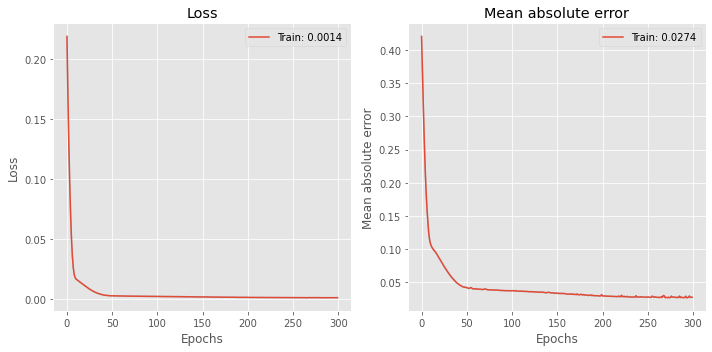

In [46]:
model.compile(loss= 'mean_squared_error', optimizer = 'adam', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=300, verbose=2).history
plot_history(history)
lstm_predict = model.predict(X_test)

# GRU

In [47]:
model = Sequential()
model.add(GRU(10, activation='tanh', batch_input_shape=(None, 1, timesteps), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(10))
model.add(Dense(1))

Epoch 1/300
7/7 - 1s - loss: 0.0970 - mean_absolute_error: 0.2750
Epoch 2/300
7/7 - 0s - loss: 0.0501 - mean_absolute_error: 0.1895
Epoch 3/300
7/7 - 0s - loss: 0.0209 - mean_absolute_error: 0.1196
Epoch 4/300
7/7 - 0s - loss: 0.0090 - mean_absolute_error: 0.0779
Epoch 5/300
7/7 - 0s - loss: 0.0082 - mean_absolute_error: 0.0709
Epoch 6/300
7/7 - 0s - loss: 0.0091 - mean_absolute_error: 0.0756
Epoch 7/300
7/7 - 0s - loss: 0.0078 - mean_absolute_error: 0.0701
Epoch 8/300
7/7 - 0s - loss: 0.0066 - mean_absolute_error: 0.0647
Epoch 9/300
7/7 - 0s - loss: 0.0059 - mean_absolute_error: 0.0616
Epoch 10/300
7/7 - 0s - loss: 0.0055 - mean_absolute_error: 0.0598
Epoch 11/300
7/7 - 0s - loss: 0.0052 - mean_absolute_error: 0.0577
Epoch 12/300
7/7 - 0s - loss: 0.0047 - mean_absolute_error: 0.0550
Epoch 13/300
7/7 - 0s - loss: 0.0044 - mean_absolute_error: 0.0524
Epoch 14/300
7/7 - 0s - loss: 0.0041 - mean_absolute_error: 0.0502
Epoch 15/300
7/7 - 0s - loss: 0.0037 - mean_absolute_error: 0.0482
Epoc

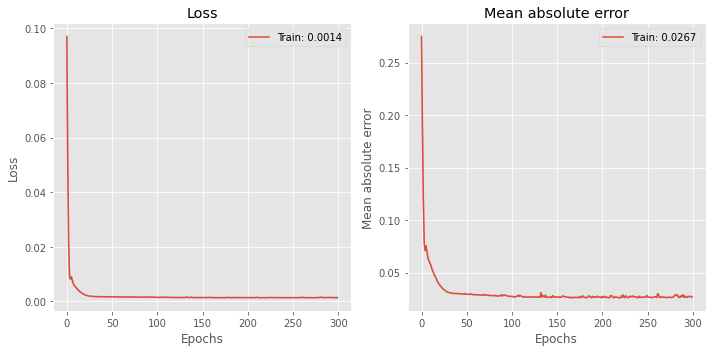

In [48]:
model.compile(loss= 'mean_squared_error', optimizer = 'adam', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=300, verbose=2).history
plot_history(history)
gru_predict = model.predict(X_test)

In [49]:
YN_test = scaler1.inverse_transform(YN_test)
YN_test = pd.DataFrame(YN_test)
YN_test.index = pd.to_datetime(data['FX'].index[half+3:])

In [50]:
lstm_predict = scaler1.inverse_transform(lstm_predict)
lstm_predict = pd.DataFrame(lstm_predict)
lstm_predict.index = pd.to_datetime(data['FX'].index[half+3:])

In [51]:
gru_predict = scaler1.inverse_transform(gru_predict)
gru_predict = pd.DataFrame(gru_predict)
gru_predict.index = pd.to_datetime(data['FX'].index[half+3:])

In [52]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(data['FX'].index[3:half+2])

# 比較

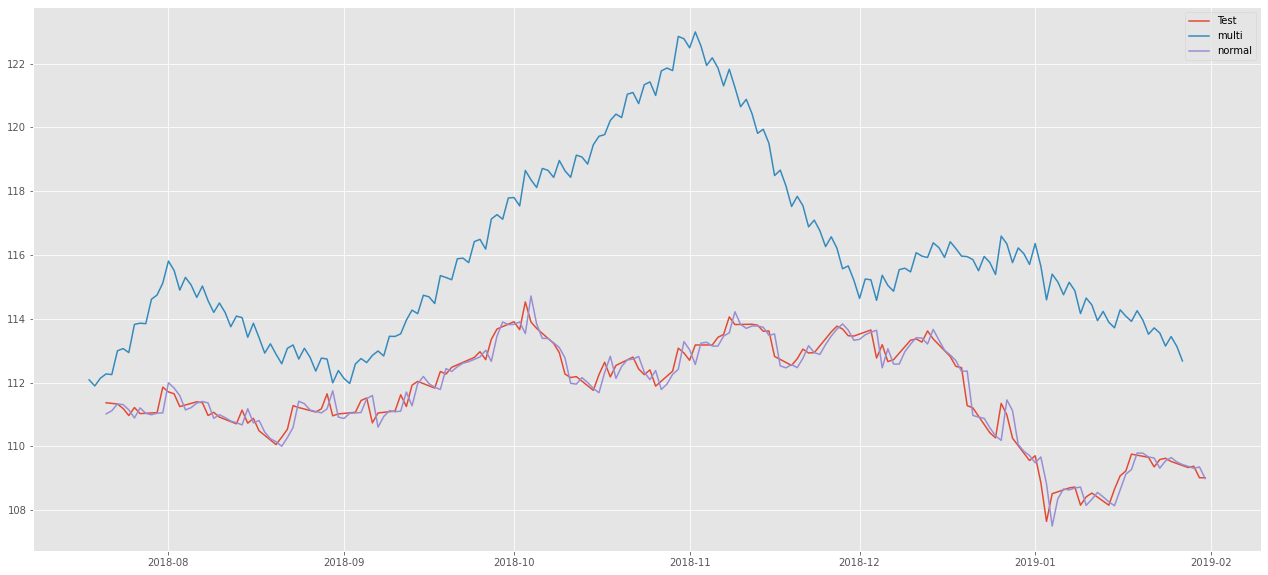

In [53]:
plt.figure(figsize=(22,10))
#plt.plot(F_lstm_test, label = 'Test')
plt.plot(YN_test, label = 'Test')
plt.plot(F_lstm_predict, label = 'multi')
plt.plot(lstm_predict, label = 'normal')
plt.legend(loc='best')
plt.savefig('卒業論文関係/FX-SPORT-multi-LSTM-epoch300.png')

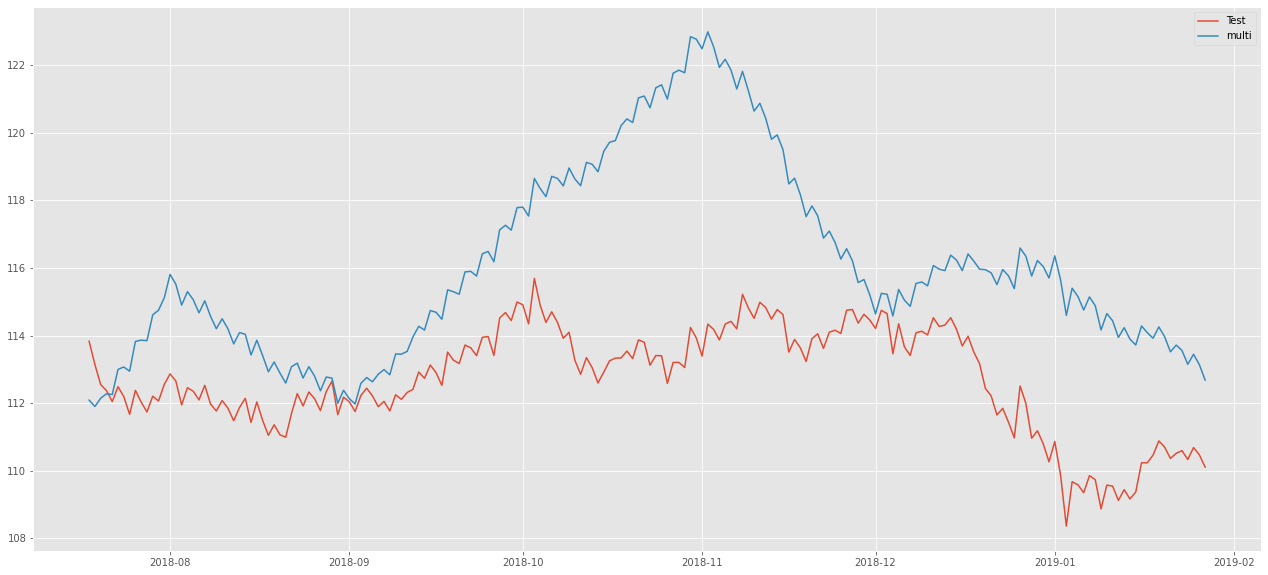

In [54]:
plt.figure(figsize=(22,10))
plt.plot(F_lstm_test, label = 'Test')
plt.plot(F_lstm_predict, label = 'multi')
plt.legend(loc='best')
#plt.savefig('画像/11-16/lstm-multi-epoch300.png')

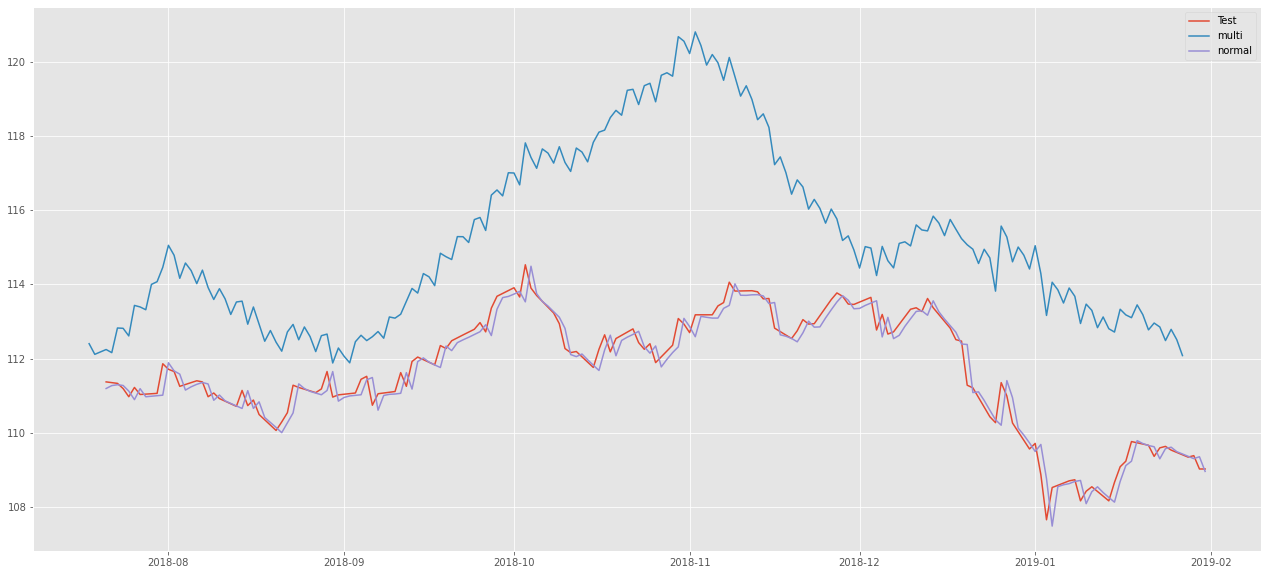

In [55]:
plt.figure(figsize=(22,10))
#plt.plot(F_gru_test, label = 'Test')
plt.plot(YN_test, label = 'Test')
plt.plot(F_gru_predict, label = 'multi')
plt.plot(gru_predict, label = 'normal')
plt.legend(loc='best')
plt.savefig('卒業論文関係/FX-SPORT-multi-GRU-epoch300-g.png')

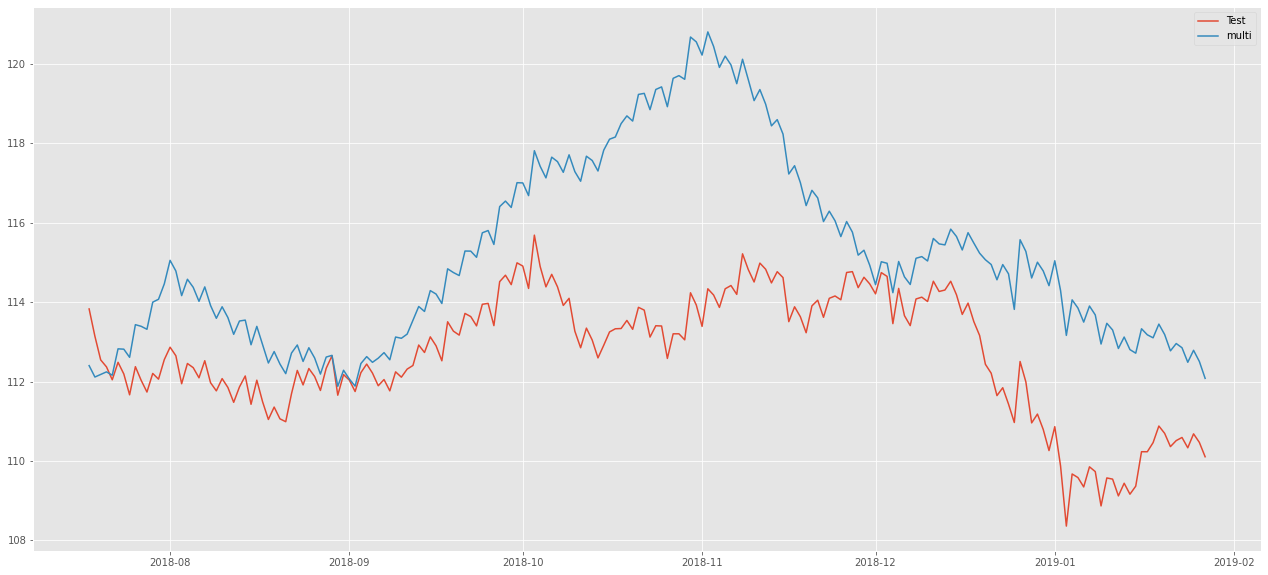

In [56]:
plt.figure(figsize=(22,10))
plt.plot(F_gru_test, label = 'Test')
plt.plot(F_gru_predict, label = 'multi')
plt.legend(loc='best')
#plt.savefig('画像/11-16/gru-multi-epoch300.png')

# RMSE

In [57]:
rmse = np.sqrt(np.average(np.subtract(F_lstm_test, F_lstm_predict) ** 2))
print('rmse:', rmse)

rmse: 4.111186915077748


In [58]:
rmse = np.sqrt(np.average(np.subtract(F_gru_test, F_gru_predict) ** 2))
print('rmse:', rmse)

rmse: 3.083137314277938


In [59]:
rmse = np.sqrt(np.average(np.subtract(YN_test, lstm_predict) ** 2))
print('rmse:', rmse)

rmse: 0.34671171198188144


In [60]:
rmse = np.sqrt(np.average(np.subtract(YN_test, gru_predict) ** 2))
print('rmse:', rmse)

rmse: 0.3382630831600218
